An important task after identifying shapes within an image is *describing*  them. This can either be done as an end in itself (say, you're trying to get the size distribution of particles within an image), or for an intermediate step for downstream processing (say you're trying to represent the shapes as features to feed into a machine learning algorithm). 

How are you going to describe these shapes? And what features contain the most "useful" information? We will look at several different types of descriptors in the notebook below. Some of these features are directly provided by `skimage`, as outputs from the `regionprops` function. Unfortunately, these are just a starting point-- and there may be other features you would like to include.

There are two broad types of features:

* **external features** characterized by the boundary of the region and
* **internal features** characterized by the pixels within the boundary.

There are three particularly useful characterizations that can be important for machine learning algorithms to ensure your features don't accidentally introduce unwanted biases. Features should be:

* **Rotation invariant**: If you rotate the shape, the feature remains the same.
* **Translation invariant**: If you translate the shape, the feature remains the same.
* **Scale invariant**: If you scale the shape, the feature remains the same.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.morphology import disk, square, star
from skimage.morphology import binary_dilation, binary_erosion, binary_closing, binary_opening
from skimage.filters import gaussian
from skimage.util import pad
from skimage.measure import regionprops_table, label
from skimage.color import label2rgb
from scipy.ndimage.morphology import binary_fill_holes

In [2]:
s1 = pad(disk(30), 9)
s2 = pad(square(31), 24)
s3 = pad(star(25), 2)
s4 = pad(disk(5), 34)

n = s1.shape[0]

In [3]:
template = np.zeros((2*n, 2*n))
template[0:n, 0:n] = s1
template[n:, 0:n] = s2
template[0:n, n:] = s3
template[n:, n:] = s4

im = np.tile(template, (4,4))

In [4]:
im_int = np.random.random(size=(500, 500))
im_int = gaussian(im_int, sigma=5)

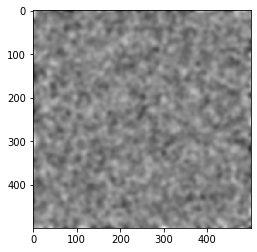

In [5]:
plt.imshow(im_int, cmap='gray')

(-0.5, 499.5, 499.5, -0.5)

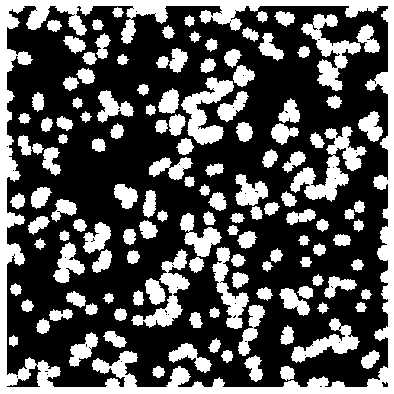

In [6]:
thresh = 0.97
im = np.random.random(size=(500, 500))
im_int = gaussian(im, sigma=2)
im = im > thresh
im = 1 - binary_closing(im, star(5))

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(im, cmap='gray')
#ax.imshow(im*im_int, cmap='gray')
ax.axis('off')

In [8]:
labels = label(im)
properties = ('area', 'bbox', 'bbox_area', 'centroid', 'convex_area', 'convex_image', 'coords', 'eccentricity', 'equivalent_diameter',
              'euler_number', 'extent', 'filled_area', 'filled_image', 'image', 'inertia_tensor', 'inertia_tensor_eigvals',
              'label', 'local_centroid', 'major_axis_length', 'moments', 'moments_central',
              'moments_hu', 'moments_normalized', 'orientation', 'perimeter', 'slice', 'solidity',
              'max_intensity', 'mean_intensity', 'min_intensity', 'intensity_image')

#regionprops()
props = regionprops_table(labels, im*im_int, properties=properties)
props = pd.DataFrame(props)
im_labels = label2rgb(labels, im)

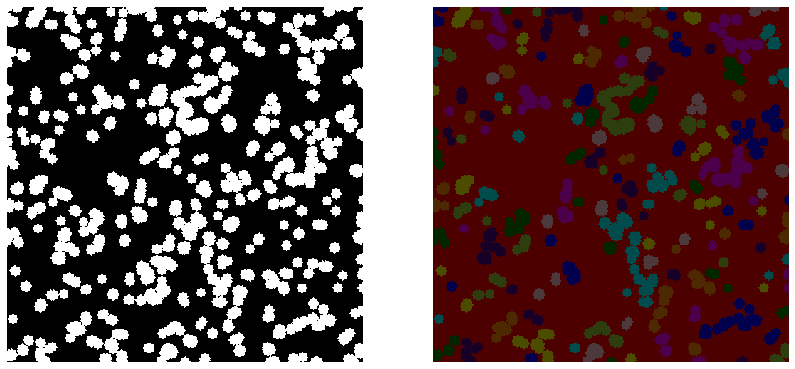

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(14,7))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(im_labels)

# Integer Descriptors

Area (mean +/- std): 417.3 +/- 419.87


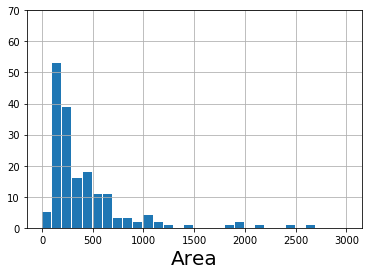

In [10]:
props.area.hist(bins=np.linspace(0, 3000, 31), width=90)
plt.xlabel('Area', fontsize=20)
plt.ylim([0,70])
print('Area (mean +/- std): {} +/- {}'.format(np.round(props.area.mean(), 1), np.round(props.area.std(), 2)))

Convex Area (mean +/- std): 460.1 +/- 550.35


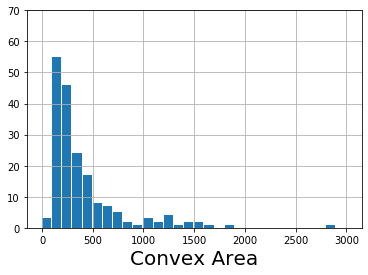

In [262]:
props.convex_area.hist(bins=np.linspace(0, 3000, 31), width=90)
plt.xlabel('Convex Area', fontsize=20)
plt.ylim([0,70])
print('Convex Area (mean +/- std): {} +/- {}'.format(np.round(props.convex_area.mean(), 1), np.round(props.convex_area.std(), 2)))

Bounding Box Area (mean +/- std): 675.8 +/- 953.57


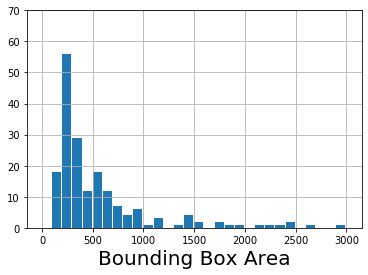

In [279]:
props.bbox_area.hist(bins=np.linspace(0, 3000, 31), width=90)
plt.xlabel('Bounding Box Area', fontsize=20)
plt.ylim([0,70])
print('Bounding Box Area (mean +/- std): {} +/- {}'.format(np.round(props.bbox_area.mean(), 1), np.round(props.bbox_area.std(), 2)))

The **extent** is a ratio of the two above quantities, the area divided by the area of the bounding box. By definition, it is between 0 and 1.

Extent Area (mean +/- std): 0.6 +/- 0.08


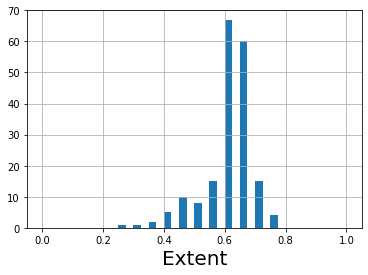

In [281]:
props.extent.hist(bins=np.linspace(0, 1, 21), width=0.025)
plt.xlabel('Extent', fontsize=20)
plt.ylim([0,70])
print('Extent Area (mean +/- std): {} +/- {}'.format(np.round(props.extent.mean(), 1), np.round(props.extent.std(), 2)))

Perimeter (mean +/- std): 88.3 +/- 67.54


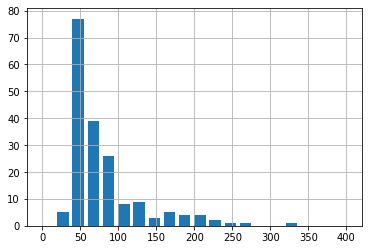

In [245]:
props.perimeter.hist(bins=np.linspace(0, 400, 21), width=15)
print('Perimeter (mean +/- std): {} +/- {}'.format(np.round(props.perimeter.mean(), 1), np.round(props.perimeter.std(), 2)))

There are actually quite a few types of descriptors not directly built into the `regionprops` function. One that may be useful is to take the ratio of the perimeter squared divided by the area. Compactness is dimensionless, insensitive to orientation, and is minimized for a disk-shaped region.

Compactness (mean +/- std): 22.4 +/- 12.67


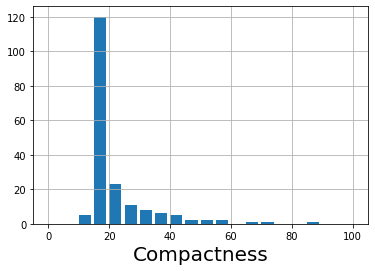

In [307]:
compactness = props.perimeter**2/props.area
compactness.hist(bins=np.linspace(0, 100, 21), width=4)
plt.xlabel('Compactness', fontsize=20)
print('Compactness (mean +/- std): {} +/- {}'.format(np.round(compactness.mean(), 1), np.round(compactness.std(), 2)))

The eccentricity is based off of the ellipse that has the same second moments as the region. The eccentricity is the ratio of the focal distance (the distance between focal points) over the major axis length.

Eccentricity (mean +/- std): 0.6 +/- 0.28


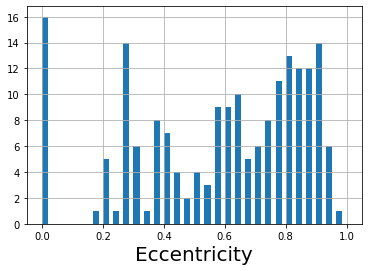

In [269]:
props.eccentricity.hist(bins=np.linspace(0, 1, 31), width=0.02)
plt.xlabel('Eccentricity', fontsize=20)
#plt.ylim([0,70])
print('Eccentricity (mean +/- std): {} +/- {}'.format(np.round(props.eccentricity.mean(), 1), np.round(props.eccentricity.std(), 2)))

**Equivalent Diameter**: The diameter of a circle with the same area as the region

Equivalent Diameter (mean +/- std): 19.9 +/- 8.09


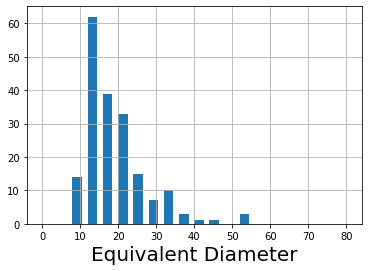

In [276]:
props.equivalent_diameter.hist(bins=np.linspace(0, 80, 21), width=2.5)
plt.xlabel('Equivalent Diameter', fontsize=20)
#plt.ylim([0,70])
print('Equivalent Diameter (mean +/- std): {} +/- {}'.format(np.round(props.equivalent_diameter.mean(), 1), np.round(props.equivalent_diameter.std(), 2)))

**Euler number**: The number of objects (presumably, 1) subracted by the number of holes.

# Coordinates

The **coords** property is an array of the coordinate pairs of each pixel in the image. We can use it to draw each individual object in the image, like so:

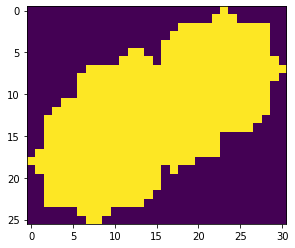

In [131]:
n = 73

max_xy = np.max(props.coords[n], axis=0)
coords = list(map(tuple, props.coords[n]))
ind_array = np.moveaxis(np.array(coords), -1, 0)

# This code shifts the coordinates for you so you don't have a lot
# of empty white space
ind_array[0, :] = ind_array[0, :] - np.min(ind_array, axis=1)[0]
ind_array[1, :] = ind_array[1, :] - np.min(ind_array, axis=1)[1]
max_xy = np.max(ind_array, axis=1)

r1 = np.zeros((max_xy[0]+1, max_xy[1]+1))
r1[tuple(ind_array)] = 1

plt.imshow(r1)

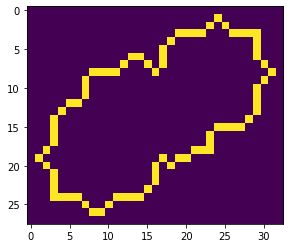

In [132]:
b1 = pad(r1, 1) - binary_erosion(pad(binary_fill_holes(r1),1), disk(1)) > 0

plt.imshow(b1)

In [27]:
# b1 = pad(r1 - binary_erosion(r1, disk(1)) > 0, 1)

# start = tuple(np.argwhere(b1)[0, :])
# Cdict = {5:0, 8:1, 7:2, 6:3, 3:4, 0:5, 1:6, 2:7}

# chain = np.array([0]*np.sum(b1))
# b1_update = np.copy(b1)

# j = 0
# for i in range(np.sum(b1)-1):
#     b1_update[start] = False

#     diffs = np.argwhere(b1_update[start[0]-1:start[0]+2, start[1]-1:start[1]+2]) - 1
#     diffs.reshape((2, int(diffs.size/2)))
#     Cs = 3*diffs[:, 1] + diffs[:, 0] + 4
#     for i, Ci in enumerate(Cs):
#         Cs[i] = Cdict[Ci]
    
#     Cfinal = int(Cs[np.argmin(np.mod(Cs, 2))])
#     chain[j] = Cfinal
#     start = tuple(np.argwhere(b1_update[start[0]-1:start[0]+2, start[1]-1:start[1]+2])[np.argmin(np.mod(Cs, 2))] + start - (1,1))
    
#     j += 1

In [143]:
def chain_representation(region):
    
    b1 = pad(r1, 1) - binary_erosion(pad(binary_fill_holes(r1),1), disk(1)) > 0

    start = tuple(np.argwhere(b1)[0, :])
    Cdict = {5:0, 8:1, 7:2, 6:3, 3:4, 0:5, 1:6, 2:7}

    chain = np.array([0]*np.sum(b1))
    x = np.array([0]*np.sum(b1))
    y = np.array([0]*np.sum(b1))
    f1 = np.array([0]*np.sum(b1))
    
    b1_update = np.copy(b1)

    j = 0
    for i in range(np.sum(b1)-1):
        b1_update[start] = False
        x[j] = start[0]
        y[j] = start[1]
        
        
        diffs = np.argwhere(b1_update[start[0]-1:start[0]+2, start[1]-1:start[1]+2]) - 1
        diffs.reshape((2, int(diffs.size/2)))
        Cs = 3*diffs[:, 1] + diffs[:, 0] + 4
        for i, Ci in enumerate(Cs):
            Cs[i] = Cdict[Ci]

        Cfinal = int(Cs[np.argmin(np.mod(Cs, 2))])
        chain[j] = Cfinal
        start = tuple(np.argwhere(b1_update[start[0]-1:start[0]+2, start[1]-1:start[1]+2])[np.argmin(np.mod(Cs, 2))] + start - (1,1))

        j += 1
    
    
    # Shape number calcuations
    chain_copy = np.append(chain, chain[-1])
    firstdiff = np.diff(chain_copy) #Rotation invariance -- counterclockwise difference
    firstdiff[firstdiff < 0] = 8 + firstdiff[firstdiff < 0]
    
    firstdiff_str = np.array2string(firstdiff, prefix='', suffix='', separator='', max_line_width=4000)
    firstdiff_str = firstdiff_str[1:-1]
    firstislast = firstdiff_str
    possibles = [0]*len(firstislast)
    possibles_int = [0]*len(firstislast)

    j = 0
    for i in range(len(firstdiff_str)):

        possibles[j] = firstislast
        possibles_int[j] = int(firstislast)
        firstislast = firstislast[1:] + firstislast[0]
        j += 1
    
    possibles_int = np.array(possibles_int)
    shapenumber = possibles[np.argmin(possibles_int)]
    shapenumber = np.array(list(shapenumber)).astype(int)
    
    f1 = x + 1j*y
        
    return chain, shapenumber, f1

In [145]:
chain, shapenumber, f1 = chain_representation(r1)

In [150]:
shapenumber

array([0, 0, 1, 0, 1, 0, 0, 7, 0, 2, 0, 7, 0, 0, 2, 0, 0, 7, 3, 0, 0, 7,
       0, 0, 1, 0, 1, 0, 7, 6, 0, 1, 1, 0, 7, 0, 0, 1, 1, 0, 7, 7, 1, 0,
       1, 0, 0, 7, 0, 2, 0, 7, 0, 0, 2, 0, 0, 7, 0, 1, 1, 0, 7, 0, 0, 1,
       0, 1, 0, 7, 6, 2, 7, 1, 7, 0, 2, 0, 7, 7])

The **centroid** gives us the coordinates of the centriod of each object. We can use it to create a map of all objects in the image

(0, 500)

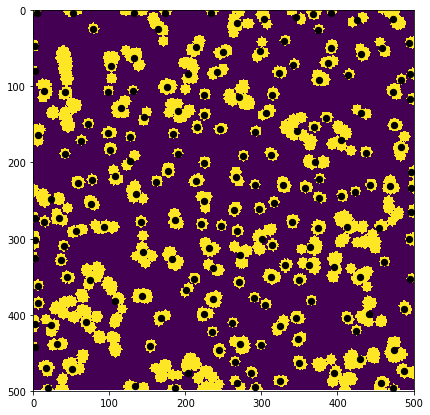

In [299]:
fig, ax = plt.subplots(figsize=(7,7))
y = props['centroid-0']
x = props['centroid-1']
ax.imshow(im)
ax.scatter(x, y, c='k', s=40)

ax.set_ylim([500,0])
ax.set_xlim([0, 500])

## Topological Descriptors

**Topology** is the study of properties of a figure that are unaffected by any deformation, as long as there is no tearing or joining of the figure e.g. even if you stretch or twist a donut, it will always have a hole:

Euler Number (mean +/- std): 0.8 +/- 0.75


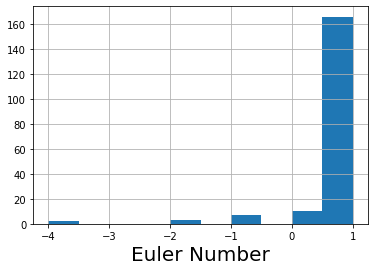

In [278]:
props.euler_number.hist()
plt.xlabel('Euler Number', fontsize=20)
#plt.ylim([0,70])
print('Euler Number (mean +/- std): {} +/- {}'.format(np.round(props.euler_number.mean(), 1), np.round(props.euler_number.std(), 2)))

## Texture

While there is no formal definition of texture, intuitively this descriptor measures properties such as smoothness, courseness, and regularity. This property can only be defined in the case when we have a non-binary image-- it's a region property, not a boundary property.

For instance, we can define the average gray level:

Extent Area (mean +/- std): 0.5 +/- 0.02


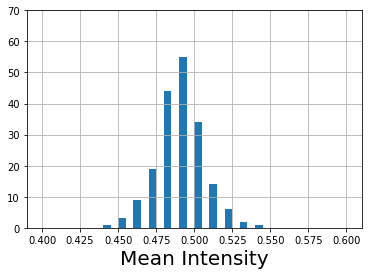

In [312]:
props.mean_intensity.hist(bins=np.linspace(0.4, 0.6, 21), width=0.005)
plt.xlabel('Mean Intensity', fontsize=20)
plt.ylim([0,70])
print('Extent Area (mean +/- std): {} +/- {}'.format(np.round(props.mean_intensity.mean(), 1), np.round(props.mean_intensity.std(), 2)))

In [345]:
intensities = props.intensity_image.values
std_int = [0]*len(intensities)
norm_std = [0]*len(intensities)

for i, intensity in enumerate(intensities):
    std_int[i] = np.std(intensity[intensity>0])
    norm_std[i] = 1 - 1/(1 + std_int[i])
    
std_int = pd.Series(std_int)
norm_std = pd.Series(norm_std)

Std Dev of Intensity (mean +/- std): 0.0 +/- 0.01


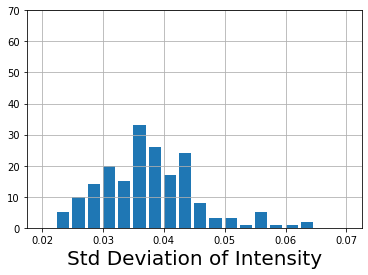

In [341]:
std_int.hist(bins=np.linspace(0.02, 0.07, 21), width=0.002)
plt.xlabel('Std Deviation of Intensity', fontsize=20)
plt.ylim([0,70])
print('Std Dev of Intensity (mean +/- std): {} +/- {}'.format(np.round(std_int.mean(), 1), np.round(std_int.std(), 2)))

Normed Std Dev of Intensity (mean +/- std): 0.0 +/- 0.01


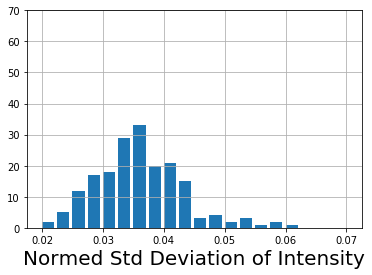

In [346]:
norm_std.hist(bins=np.linspace(0.02, 0.07, 21), width=0.002)
plt.xlabel('Normed Std Deviation of Intensity', fontsize=20)
plt.ylim([0,70])
print('Normed Std Dev of Intensity (mean +/- std): {} +/- {}'.format(np.round(norm_std.mean(), 1), np.round(norm_std.std(), 2)))

You can similar calculate higher moments of the intensity histogram, such as the third moment (skewness) and the forth moment, a measure of relative flatness. Higher moments aren't as easily interpretable, but can be used to further discriminate between texture content.